# 0. Import packages

In [94]:
import os
%matplotlib widget
from dtscalibration import read_silixa_files
import matplotlib.pyplot as plt
import warnings
import glob
import dtscalibration
import pickle as pkl

import numpy as np
import pandas as pd
import scipy.stats as st 
from scipy import signal
import scipy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import os
import warnings

from dtscalibration import read_silixa_files
from dtscalibration.dts_accessor_utils import (
    suggest_cable_shift_double_ended,
    shift_double_ended,
)
from dtscalibration.variance_stokes import variance_stokes_constant, variance_stokes_linear, variance_stokes_exponential
warnings.simplefilter("ignore")  # Hide warnings to avoid clutter in the notebook

# 00. Make necessary functions

In [3]:
def interpolate_2d_grid(left_boundary, right_boundary, num_columns):
    """
    Interpolates a 2D grid between two lines acting as the left and right boundary conditions.
    
    Parameters:
    left_boundary: list of tuples (x, y), the left boundary line's points
    right_boundary: list of tuples (x, y), the right boundary line's points
    num_columns: int, number of interpolation points (columns) in the grid between the boundaries

    Returns:
    grid: 2D numpy array representing the interpolated grid
    """
    # Ensure both boundaries have the same number of points (rows)
    assert len(left_boundary) == len(right_boundary), "Left and right boundaries must have the same number of points"
    
    # Number of rows in the grid
    num_rows = len(left_boundary)
    
    # Initialize the grid
    grid = np.zeros((num_rows, num_columns, 2))
    
    # Interpolate each row between the corresponding points on the left and right boundaries
    for i in range(num_rows):
        p_left = np.array(left_boundary[i])
        p_right = np.array(right_boundary[i])
        
        # Interpolate linearly between left and right boundaries for each row
        for j, t in enumerate(np.linspace(0, 1, num_columns)):
            grid[i, j, :] = p_left * (1 - t) + p_right * t
    
    return grid

def merge(temp, depth, num_points):
    """
    Resamples temperature and depth data to a specified number of points.
    
    Args:
        temp (list): Temperature values.
        depth (list): Depth values.
        num_points (int): Number of samples in output.
    
    Returns:
        list of tuples: List of (temp, depth) tuples resampled to num_points.
    """
    temp = np.array(temp)[::-1]
    depth = np.array(depth)[::-1]

    # Ensure inputs are same length
    if len(temp) != len(depth):
        raise ValueError("Temperature and depth lists must be the same length.")

    # Interpolation over depth
    interp_depth = np.linspace(depth.min(), depth.max(), num_points)
    interp_temp = np.interp(interp_depth, depth, temp)

    merged = list(zip(interp_temp, interp_depth))
    return merged

# 1. Load temp and get the borehole temps
### See Fig2_boreholeTemps.ipynb for more description

In [95]:
all_ds = {}

for i in glob.glob('../../Antarctica_DTS_allData/files_sorted_by_borehole/*'):

    ds = dtscalibration.read_silixa_files(
        directory=i,
        timezone_netcdf='UTC',
        file_ext='*.xml')
    

    # fig,ax = plt.subplots()
    # # ax.plot(ds.x, ds.dts.st)
    # ax.plot(ds.x, ds.dts.st)
    # ax.set_title(i[-12:])

    # ax1 = ax.twinx()
    # ax1.plot(ds.x, ds.tmp)
    # ax1.set_ylim([-35,-25])

    all_ds[i[-12:]] = ds

borehole_depths = {
    'ALHIC1901_22': [161, 314],
    'ALHIC1901_23': [170.7, 311.74],
    'ALHIC1901_24': [170.7, 312.3],
    'ALHIC1902_23': [104.5, 312.1],
    'ALHIC1903_23': [163.8, 311.7],
    'ALHIC2201_23': [220.3, 311.7],
    'ALHIC2301_23': [220.8, 312.03],
    'ALHIC2301_24': [220, 312.3],
    'ALHIC2302_24': [99, 312.3],
    'ALHIC2401_24': [220.27, 312.3],
}

# Taken from REMA
borehole_elevations = {
    'ALHIC1901_22': 1937.88,
    'ALHIC1901_23': 1937.88,
    'ALHIC1901_24': 1937.88,
    'ALHIC1902_23': 1940.76,
    'ALHIC1903_23': 1884.84,
    'ALHIC2201_23': 1934.54,
    'ALHIC2301_23': 1865.68,
    'ALHIC2301_24': 1865.68,
    'ALHIC2302_24': 1940.76,
    'ALHIC2401_24': 1865.68,
}

boreholes = ['ALHIC1901', 'ALHIC1902', 'ALHIC1903', 'ALHIC2201', 'ALHIC2301', 'ALHIC2302', 'ALHIC2401']

avg_temps = {}
avg_residuals = {}

for i in all_ds:

    z1, z2 = borehole_depths[i]
    if i == 'ALHIC1901_24':
        ds = all_ds[i].isel(time=list(np.arange(2,len(ds),1)))
    else:
        ds = all_ds[i]
    
    for borehole in boreholes:

        if i.startswith(borehole):
            depth = ds.sel(x=slice(z1, z2)).x - ds.sel(x=slice(z1, z2)).x[0]
            temp = ds.sel(x=slice(z1, z2)).tmp
            bor_elev = borehole_elevations[i]
            elevs = bor_elev-depth

            temp_avg = np.mean(temp, axis=1)
            residual = signal.detrend(temp_avg[90:])
            avg_temps[i] = (elevs, depth, temp_avg)
            avg_residuals[i] = (elevs[90:], depth[90:], residual)

with open('../Borehole_Temps/avg_temps.pkl', 'wb') as file:
    pkl.dump(avg_temps, file)

with open('../Borehole_Temps/residual_temps.pkl', 'wb') as file:
    pkl.dump(avg_residuals, file)

3 files were found, each representing a single timestep
6 recorded vars were found: LAF, ST, AST, REV-ST, REV-AST, TMP
Recorded at 3553 points along the cable
The measurement is double ended
Reading the data from disk
12 files were found, each representing a single timestep
6 recorded vars were found: LAF, ST, AST, REV-ST, REV-AST, TMP
Recorded at 3537 points along the cable
The measurement is double ended
Reading the data from disk
92 files were found, each representing a single timestep
6 recorded vars were found: LAF, ST, AST, REV-ST, REV-AST, TMP
Recorded at 3537 points along the cable
The measurement is double ended
Reading the data from disk
31 files were found, each representing a single timestep
6 recorded vars were found: LAF, ST, AST, REV-ST, REV-AST, TMP
Recorded at 3537 points along the cable
The measurement is double ended
Reading the data from disk
2 files were found, each representing a single timestep
6 recorded vars were found: LAF, ST, AST, REV-ST, REV-AST, TMP
Record

In [5]:
# in km
distances_between_boreholes = {
    'ALHIC1903_ALHIC1901': 3.5,
    'ALHIC1901_ALHIC1902': 1.5,
    'ALHIC1902_ALHIC2301': 2.0,
    'ALHIC1902_ALHIC2302': .02,
    'ALHIC1901_ALHIC2201': .1,
    'ALHIC2301_ALHIC2401': .01
}

# 2. Plot the real temps

In [92]:
ALHIC1903 = merge(avg_temps['ALHIC1903_23'][2].values, avg_temps['ALHIC1903_23'][0].values, 100)
ALHIC1901 = merge(avg_temps['ALHIC1901_22'][2].values, avg_temps['ALHIC1901_22'][0].values, 100)
ALHIC1902 = merge(avg_temps['ALHIC1902_23'][2].values, avg_temps['ALHIC1902_23'][0].values, 100)
ALHIC2201 = merge(avg_temps['ALHIC2201_23'][2].values, avg_temps['ALHIC2201_23'][0].values, 100)
ALHIC2301 = merge(avg_temps['ALHIC2301_24'][2].values, avg_temps['ALHIC2301_24'][0].values, 100)
ALHIC2401 = merge(avg_temps['ALHIC2401_24'][2].values, avg_temps['ALHIC2401_24'][0].values, 100)
ALHIC2302 = merge(avg_temps['ALHIC2302_24'][2].values, avg_temps['ALHIC2302_24'][0].values, 100)

km_per_col_cross = .2
km_per_col_along = .01

grid_1903_1901 = interpolate_2d_grid(ALHIC1903, ALHIC1901, int(distances_between_boreholes['ALHIC1903_ALHIC1901'] / km_per_col_cross))
grid_1901_1902 = interpolate_2d_grid(ALHIC1901, ALHIC1902, int(distances_between_boreholes['ALHIC1901_ALHIC1902'] / km_per_col_cross))
grid_1902_2301 = interpolate_2d_grid(ALHIC1902, ALHIC2301, int(distances_between_boreholes['ALHIC1902_ALHIC2301'] / km_per_col_cross))
grid_1901_2201 = interpolate_2d_grid(ALHIC1901, ALHIC2201, int(distances_between_boreholes['ALHIC1901_ALHIC2201'] / km_per_col_along))
grid_2301_2401 = interpolate_2d_grid(ALHIC2301, ALHIC2401, int(distances_between_boreholes['ALHIC2301_ALHIC2401'] / .005))
grid_1902_2302 = interpolate_2d_grid(ALHIC1902, ALHIC2302, int(distances_between_boreholes['ALHIC1902_ALHIC2302'] / km_per_col_along))

cross_flow_view = np.concatenate((grid_1903_1901, grid_1901_1902, grid_1902_2301), axis=1)
cross_flow_cols = int(distances_between_boreholes['ALHIC1903_ALHIC1901'] / km_per_col_cross) + int(distances_between_boreholes['ALHIC1901_ALHIC1902'] / km_per_col_cross) + int(distances_between_boreholes['ALHIC1902_ALHIC2301'] / km_per_col_cross)
cross_flow_distance = distances_between_boreholes['ALHIC1903_ALHIC1901'] + distances_between_boreholes['ALHIC1901_ALHIC1902'] + distances_between_boreholes['ALHIC1902_ALHIC2301']


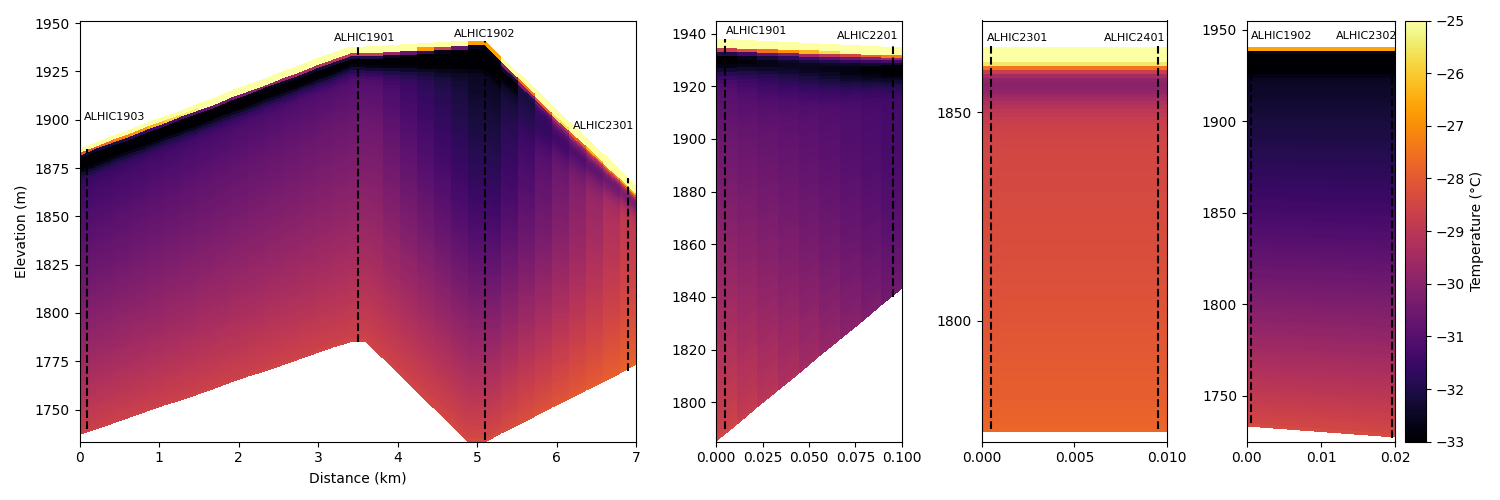

In [93]:
fig,axes = plt.subplots(1,4, gridspec_kw={'width_ratios': [3, 1, 1, 1]}, figsize=(15, 5))
vmin = -33
vmax = -25

im1 = axes[0].pcolormesh(np.linspace(0,cross_flow_distance,cross_flow_cols), cross_flow_view[:,:,1], cross_flow_view[:,:,0], cmap='inferno', vmax= vmax, vmin = vmin)


im2 = axes[1].pcolormesh(np.linspace(0,distances_between_boreholes['ALHIC1901_ALHIC2201'],int(distances_between_boreholes['ALHIC1901_ALHIC2201'] / km_per_col_along) ), 
                        grid_1901_2201[:,:,1], grid_1901_2201[:,:,0], cmap='inferno', vmax= vmax, vmin = vmin)


im3 = axes[2].pcolormesh(np.linspace(0,distances_between_boreholes['ALHIC2301_ALHIC2401'],int(distances_between_boreholes['ALHIC2301_ALHIC2401'] / .005) ), 
                        grid_2301_2401[:,:,1], grid_2301_2401[:,:,0], cmap='inferno', vmax= vmax, vmin = vmin)
axes[2].locator_params(nbins=3)

im4 = axes[3].pcolormesh(np.linspace(0,distances_between_boreholes['ALHIC1902_ALHIC2302'],int(distances_between_boreholes['ALHIC1902_ALHIC2302'] / km_per_col_along) ), 
                        grid_1902_2302[:,:,1], grid_1902_2302[:,:,0], cmap='inferno', vmax= vmax, vmin = vmin)
cbar = fig.colorbar(im4, ax=axes[3], label='Temperature (°C)')



## Boreholes (first plot)
axes[0].plot([0.1,0.1], [1740,1885], ls='--', c='black')
axes[0].plot([3.5,3.5], [1785,1939], ls='--', c='black')
axes[0].plot([5.1,5.1], [1734,1941], ls='--', c='black')
axes[0].plot([6.9,6.9], [1770,1870], ls='--', c='black')


axes[0].annotate('ALHIC1903', xy=(0.1,1865), xytext=(0.05,1900), fontsize=8)
axes[0].annotate('ALHIC1901', xy=(3.5,1915), xytext=(3.2,1941), fontsize=8)
axes[0].annotate('ALHIC1902', xy=(5.1,1918), xytext=(4.7,1943), fontsize=8)
axes[0].annotate('ALHIC2301', xy=(6.9,1850), xytext=(6.20,1895), fontsize=8)

## Boreholes (second plot)
axes[1].plot([0.005,0.005], [1790,1938], ls='--', c='black')
axes[1].plot([0.095,0.095], [1840,1936], ls='--', c='black')

axes[1].annotate('ALHIC1901', xy=(0.005,1915), xytext=(0.005,1940), fontsize=8)
axes[1].annotate('ALHIC2201', xy=(0.095,1912), xytext=(0.065,1938), fontsize=8)
axes[1].set_ylim([1785,1945])

## Boreholes (third plot)
axes[2].plot([0.0005,0.0005], [1774,1866], ls='--', c='black')
axes[2].plot([0.0095,0.0095], [1774,1866], ls='--', c='black')

axes[2].annotate('ALHIC2301', xy=(0.0005,1863), xytext=(0.0003,1867), fontsize=8)
axes[2].annotate('ALHIC2401', xy=(0.0095,1863), xytext=(0.0066,1867), fontsize=8)
axes[2].set_ylim([1771,1872])

# Boreholes (fourth plot)
axes[3].plot([0.0005,0.0005], [1735,1938], ls='--', c='black')
axes[3].plot([0.0195,0.0195], [1727,1938], ls='--', c='black')

axes[3].annotate('ALHIC1902', xy=(0.0005,1919), xytext=(0.0005,1945), fontsize=8)
axes[3].annotate('ALHIC2302', xy=(0.0125,1918), xytext=(0.012,1945), fontsize=8)
axes[3].set_ylim([1725,1955])

axes[0].set_xlabel('Distance (km)')
axes[0].set_ylabel('Elevation (m)')


plt.tight_layout()
plt.savefig('Fig2_alt_a.png')

# 3. Plot the temp residuals

In [89]:
ALHIC1903 = merge(avg_residuals['ALHIC1903_23'][2], avg_residuals['ALHIC1903_23'][0], 100)
ALHIC1901 = merge(avg_residuals['ALHIC1901_22'][2], avg_residuals['ALHIC1901_22'][0], 100)
ALHIC1902 = merge(avg_residuals['ALHIC1902_23'][2], avg_residuals['ALHIC1902_23'][0], 100)
ALHIC2201 = merge(avg_residuals['ALHIC2201_23'][2], avg_residuals['ALHIC2201_23'][0], 100)
ALHIC2301 = merge(avg_residuals['ALHIC2301_24'][2], avg_residuals['ALHIC2301_24'][0], 100)
ALHIC2401 = merge(avg_residuals['ALHIC2401_24'][2], avg_residuals['ALHIC2401_24'][0], 100)
ALHIC2302 = merge(avg_residuals['ALHIC2302_24'][2], avg_residuals['ALHIC2302_24'][0], 100)

km_per_col_cross = .25
km_per_col_along = .01

grid_1903_1901 = interpolate_2d_grid(ALHIC1903, ALHIC1901, int(distances_between_boreholes['ALHIC1903_ALHIC1901'] / km_per_col_cross))
grid_1901_1902 = interpolate_2d_grid(ALHIC1901, ALHIC1902, int(distances_between_boreholes['ALHIC1901_ALHIC1902'] / km_per_col_cross))
grid_1902_2301 = interpolate_2d_grid(ALHIC1902, ALHIC2301, int(distances_between_boreholes['ALHIC1902_ALHIC2301'] / km_per_col_cross))
grid_1901_2201 = interpolate_2d_grid(ALHIC1901, ALHIC2201, int(distances_between_boreholes['ALHIC1901_ALHIC2201'] / km_per_col_along))
grid_2301_2401 = interpolate_2d_grid(ALHIC2301, ALHIC2401, int(distances_between_boreholes['ALHIC2301_ALHIC2401'] / .005))
grid_1902_2302 = interpolate_2d_grid(ALHIC1902, ALHIC2302, int(distances_between_boreholes['ALHIC1902_ALHIC2302'] / .001))

cross_flow_view = np.concatenate((grid_1903_1901, grid_1901_1902, grid_1902_2301), axis=1)
cross_flow_cols = int(distances_between_boreholes['ALHIC1903_ALHIC1901'] / km_per_col_cross) + int(distances_between_boreholes['ALHIC1901_ALHIC1902'] / km_per_col_cross) + int(distances_between_boreholes['ALHIC1902_ALHIC2301'] / km_per_col_cross)
cross_flow_distance = distances_between_boreholes['ALHIC1903_ALHIC1901'] + distances_between_boreholes['ALHIC1901_ALHIC1902'] + distances_between_boreholes['ALHIC1902_ALHIC2301']

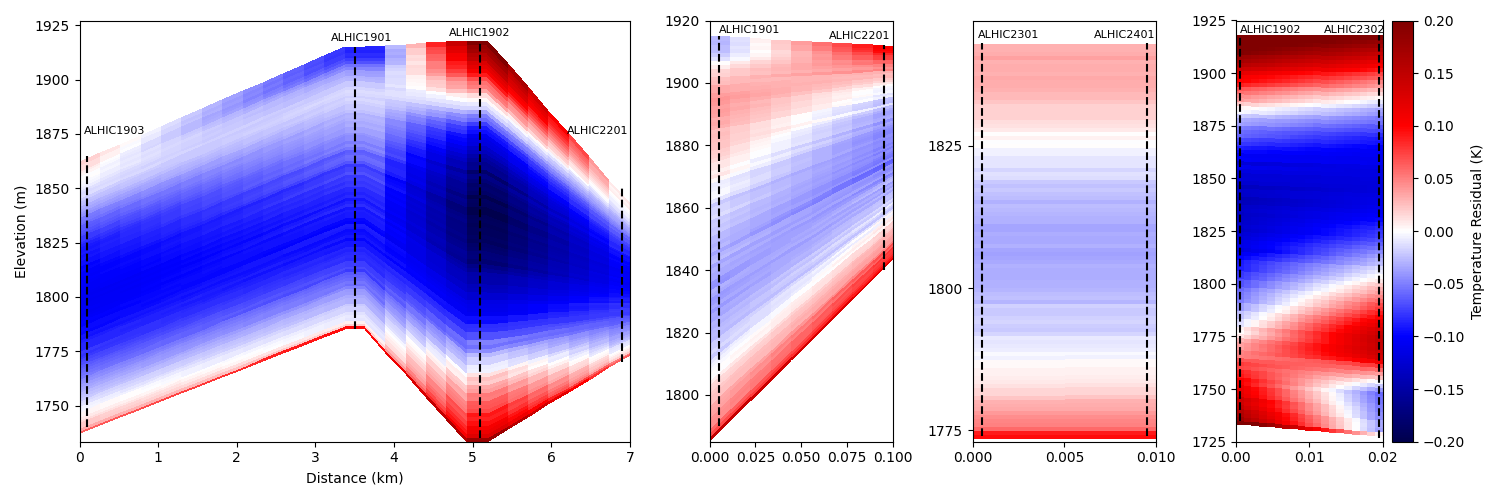

In [91]:
fig,axes = plt.subplots(1,4, gridspec_kw={'width_ratios': [3, 1, 1, 1]}, figsize=(15, 5))
vmin = -0.2
vmax = 0.2
im1 = axes[0].pcolormesh(np.linspace(0,cross_flow_distance,cross_flow_cols), cross_flow_view[:,:,1], cross_flow_view[:,:,0], cmap='seismic')


im2 = axes[1].pcolormesh(np.linspace(0,distances_between_boreholes['ALHIC1901_ALHIC2201'],int(distances_between_boreholes['ALHIC1901_ALHIC2201'] / km_per_col_along) ), 
                        grid_1901_2201[:,:,1], grid_1901_2201[:,:,0], cmap='seismic', vmin = vmin, vmax = vmax)


im3 = axes[2].pcolormesh(np.linspace(0,distances_between_boreholes['ALHIC2301_ALHIC2401'],int(distances_between_boreholes['ALHIC2301_ALHIC2401'] / .005) ), 
                        grid_2301_2401[:,:,1], grid_2301_2401[:,:,0], cmap='seismic', vmin = vmin, vmax = vmax)
axes[2].locator_params(nbins=3)

im4 = axes[3].pcolormesh(np.linspace(0,distances_between_boreholes['ALHIC1902_ALHIC2302'],int(distances_between_boreholes['ALHIC1902_ALHIC2302'] / 0.001) ), 
                        grid_1902_2302[:,:,1], grid_1902_2302[:,:,0], cmap='seismic', vmin = vmin, vmax = vmax)

cbar = fig.colorbar(im4, ax=axes[3], label= 'Temperature Residual (K)')

## Boreholes (first plot)
axes[0].plot([0.1,0.1], [1740,1865], ls='--', c='black')
axes[0].plot([3.5,3.5], [1785,1915], ls='--', c='black')
axes[0].plot([5.1,5.1], [1735,1918], ls='--', c='black')
axes[0].plot([6.9,6.9], [1770,1850], ls='--', c='black')


axes[0].annotate('ALHIC1903', xy=(0.1,1865), xytext=(0.05,1875), fontsize=8)
axes[0].annotate('ALHIC1901', xy=(3.5,1915), xytext=(3.2,1918), fontsize=8)
axes[0].annotate('ALHIC1902', xy=(5.1,1918), xytext=(4.7,1920), fontsize=8)
axes[0].annotate('ALHIC2201', xy=(6.9,1850), xytext=(6.20,1875), fontsize=8)

## Boreholes (second plot)
axes[1].plot([0.005,0.005], [1790,1915], ls='--', c='black')
axes[1].plot([0.095,0.095], [1840,1912], ls='--', c='black')

axes[1].annotate('ALHIC1901', xy=(0.005,1915), xytext=(0.005,1916), fontsize=8)
axes[1].annotate('ALHIC2201', xy=(0.095,1912), xytext=(0.065,1914), fontsize=8)
axes[1].set_ylim([1785,1920])

## Boreholes (third plot)
axes[2].plot([0.0005,0.0005], [1774,1843], ls='--', c='black')
axes[2].plot([0.0095,0.0095], [1774,1843], ls='--', c='black')

axes[2].annotate('ALHIC2301', xy=(0.0005,1843), xytext=(0.0003,1844), fontsize=8)
axes[2].annotate('ALHIC2401', xy=(0.0095,1843), xytext=(0.0066,1844), fontsize=8)
axes[2].set_ylim([1773,1847])

# Boreholes (fourth plot)
axes[3].plot([0.0005,0.0005], [1735,1918], ls='--', c='black')
axes[3].plot([0.0195,0.0195], [1727,1918], ls='--', c='black')

axes[3].annotate('ALHIC1902', xy=(0.0005,1919), xytext=(0.0005,1919), fontsize=8)
axes[3].annotate('ALHIC2302', xy=(0.0125,1918), xytext=(0.012,1919), fontsize=8)
axes[3].set_ylim([1725,1925])

axes[0].set_xlabel('Distance (km)')
axes[0].set_ylabel('Elevation (m)')

plt.tight_layout()

plt.savefig('Fig2_alt_b.png')